# Spam filter analysis: instance weighting
Based on the PhD thesis of [Jing Jiang (2008)](https://www.ideals.illinois.edu/bitstream/handle/2142/10870/UIUCDCS-R-2008-2974.pdf?sequence=2)

Data from the [ECML KPDD Challenge 2006](http://ecmlpkdd2006.org/challenge.html#download)

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
def read_data(file_name):
    with open(file_name, 'r') as content_file:
        content = content_file.read()
    content = content.split()
    cnt = 0
    split = []
    buffer = []
    label = []
    feature_max = 0
    for item in content:
        if item == '1' or item == '-1':
            split.append(cnt)
            if item == '1':
                label.append(1)
            else:
                label.append(0)
            if cnt > 1 and buffer[-1][0] > feature_max:
                feature_max = buffer[-1][0]
        else:
            buffer.append([int(i) for i in item.split(':')]) 
            cnt += 1
    # Convert the data into a matrix
    X = np.empty((len(split), feature_max+1))
    split.append(len(buffer))
    for i in range(len(split)-1):
        for j in range(split[i], split[i+1]):
            X[i, buffer[j][0]] = buffer[j][1]
    Y = label
    return X, Y

In [3]:
src = 'source'
tgt = 'user 1'
X_src, Y_src = read_data('data_task_a/task_a_labeled_train.tf')
Ns = np.size(X_src,0)

In [4]:
X_tgt, Y_tgt = read_data('data_task_a/task_a_u00_eval_lab.tf')
# Note that X_test is not the same size as X_train
tmp = np.zeros((np.size(X_tgt,0), np.size(X_src,1)))
tmp[:, :np.size(X_tgt,1)] = X_tgt
X_tgt = tmp

In [5]:
# Reduce the number of features
feature_count = np.sum(X_src,0)
sort_idx = np.argsort(feature_count)
X_src = X_src[:, sort_idx[-10000:]]
X_tgt =  X_tgt[:, sort_idx[-10000:]]

In [6]:
# Base case
model = LogisticRegression(C = 1) # Regularisation parameter C = 1
model.fit(X_src, Y_src)
print('train {:s} acc: {:.3f}, test {:s} acc: {:.3f}'\
      .format(src, model.score(X_src, Y_src), tgt, model.score(X_tgt,Y_tgt)))

train source acc: 1.000, test user 1 acc: 0.621


In [7]:
# Test the sensitivity to regularisation parameter
C_test = np.linspace(0.1,2,20)
acc_train = []
acc_dev = []
for C in C_test:
    model_BL = LogisticRegression(C = C) 
    model_BL.fit(X_src, Y_src)
    acc_train.append(model_BL.score(X_src, Y_src))
    acc_dev.append(model_BL.score(X_tgt, Y_tgt))

optimal alpha 0.3 train acc 0.9995 max acc 0.628


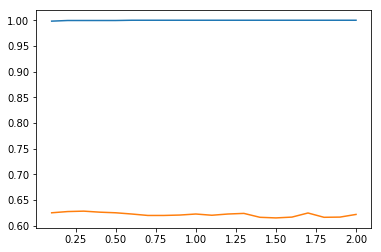

In [8]:
C_opt = C_test[np.argmax(acc_dev)]
model_BL = LogisticRegression(C = C_opt) 
model_BL.fit(X_src, Y_src)
print('optimal alpha', C_opt, 'train acc', model_BL.score(X_src, Y_src), 'max acc', max(acc_dev))
plt.plot(C_test, acc_train)
plt.plot(C_test, acc_dev)

In [9]:
C_opt = 1
model_BL = LogisticRegression(C = C_opt) 
model_BL.fit(X_src, Y_src)
print('Baseline', C_opt, 'train acc', model.score(X_src, Y_src), 'max acc', max(acc_dev))

Baseline 1 train acc 1.0 max acc 0.628


# Instance weighting: $\alpha$

Weight each example using $\frac{P_t(x^s_i)}{P_s(x^s_i)}$

In [10]:
def mean_error_fixed_size_alpha(X_s, X_t, Y_s, Y_t):
    Ns = np.size(X_s,0)
    err_alpha = []
    X_scr_tgt = np.r_[X_s, X_t]
    # Build the classifier for source VS target
    Y_scr_tgt = np.r_[np.zeros(np.size(X_s,0)),np.ones(np.size(X_t,0))]
    model_src_tgt = LogisticRegression(C = 1)
    model_src_tgt.fit(X_scr_tgt, Y_scr_tgt)
    # This model is P(target|x), from which we can estimate alpha
    p_src_tgt = model_src_tgt.predict_proba(X_s)
    alpha_initial = p_src_tgt[:,1]/p_src_tgt[:,0]
    plt.hist(alpha_initial, bins = 20)
    C = np.sum(alpha_initial)
    alpha = alpha_initial/C*Ns
    # Weight each sample with alpha
    model = LogisticRegression(C = 1)
    model.fit(X_s,Y_s,alpha)
    print('baseline src only:', model.score(X_t, Y_t))

test source to user 1 with alpha weighting
baseline src only: 0.6072


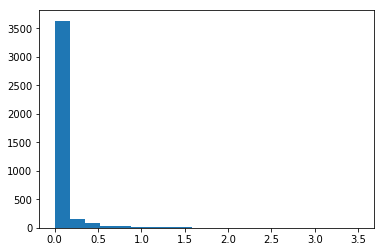

In [11]:
print('test {} to {} with alpha weighting'.format( src, tgt))
mean_error_fixed_size_alpha(X_src, X_tgt, Y_src, Y_tgt)

## Semi-supervised learning
Semi-supervised learning with a small number of labeled target data.

Models
- Baseline with source only
- $\beta$ weighting using a model trained on the labeled target data: $\beta = \frac{P_t(y^s_i|x^s_i)}{P_s(y^s_i|x^s_i)}$
- baseline with source + labeled target data
- source + labeled target data + beta weighting
- source + up-weighted labeled target data

In [12]:
def compute_beta(model_BL, model_tgt_labeled, X_s, Y_s):
    selection = [[True, False],[False,True]]
    idx = [selection[i] for i in Y_s]
    idx = []
    for i in Y_s:
        if i == 1:
            idx.append(selection[1])
        else:
            idx.append(selection[0])
    prob_tgt = model_tgt_labeled.predict_proba(X_s)
    prob_tgt = prob_tgt[idx]
    prob_BL = model_BL.predict_proba(X_s)
    prob_BL = prob_BL[idx]
    beta_initial = prob_tgt/prob_BL
    return beta_initial

In [13]:
def mean_error_fixed_size(X_s, X_t, Y_s, Y_t, test_size, Nrepeat):
    Ns = np.size(X_s,0)
    err_BL = []
    err_BL2 = []
    err_BAL = []
    err_beta = []
    err_beta2 = []
    n_t_l = test_size
    for i in range(Nrepeat):
        # get labeled target data
        X_tu, X_tl, Y_tu, Y_tl = train_test_split(X_t, Y_t, test_size = test_size, random_state = i)
        X_train_full = np.r_[X_s, X_tl]
        Y_train_full = np.r_[Y_s, Y_tl]
        
        # Baseline for source
        model_BL = LogisticRegression(C = 1)
        model_BL.fit(X_s,Y_s)
        err_BL.append(model_BL.score(X_tu, Y_tu))
        
        # beta-weighting
        model_tgt_labeled = LogisticRegression(C = 1)
        model_tgt_labeled.fit(X_tl,Y_tl)
        beta = compute_beta(model_BL, model_tgt_labeled, X_s, Y_s)
        beta = beta/np.sum(beta)*Ns
        model2_beta = LogisticRegression(C = 1)
        model2_beta.fit(X_s,Y_s,beta)
        err_beta.append(model2_beta.score(X_tu, Y_tu))

        # Baseline with target data
        model2_BL = LogisticRegression(C = 1)
        model2_BL.fit(X_train_full,Y_train_full)
        err_BL2.append(model2_BL.score(X_tu, Y_tu))
        
        # beta with labeled target data
        beta = np.r_[beta, np.ones(n_t_l)]
        model2_beta = LogisticRegression(C = 1)
        model2_beta.fit(X_train_full,Y_train_full,beta)
        err_beta2.append(model2_beta.score(X_tu, Y_tu))

        # Balanced (upweight target domain)
        weight_BAL = np.r_[np.ones(Ns), Ns/n_t_l*np.ones(n_t_l)]
        model2_BAL = LogisticRegression(C = 1)
        model2_BAL.fit(X_train_full,Y_train_full, weight_BAL)
        err_BAL.append(model2_BAL.score(X_tu, Y_tu))

#         print('iter: {:d}, BL train acc: {:.3f}, test acc: {:.3f}'\
#               .format(i+1, model2_BL.score(X_train_full,Y_train_full), err_BL[-1]))
#         print('BAL train acc: {:.3f}, test acc: {:.3f}'\
#               .format(model2_BAL.score(X_train_full,Y_train_full), err_BAL[-1]))
#         print('beta train acc: {:.3f}, test acc: {:.3f}'\
#               .format(model2_beta.score(X_train_full,Y_train_full), err_beta[-1]))
    np.set_printoptions(precision=3)
    print('baseline src only:', np.asarray(err_BL))
    print('beta weighting', np.asarray(err_beta))
    print('baseline src + lt', np.asarray(err_BL2))
    print('src + lt + beta', np.asarray(err_beta2))
    print('upweighted tgt domain', np.asarray(err_BAL))
    return [np.mean(err_BL), np.mean(err_beta), np.mean(err_BL2), \
            np.mean(err_beta2), np.mean(err_BAL)]

In [14]:
test_size = 80
Nrepeat = 8
full_results = []
print('test {} to {} with labeled target size {}'.format( src, tgt, test_size))
full_results.append(mean_error_fixed_size(X_src, X_tgt, Y_src, Y_tgt, test_size, Nrepeat))

test source to user 1 with labeled target size 80


/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


baseline src only: [ 0.623  0.62   0.62   0.617  0.619  0.621  0.621  0.622]
beta weighting [ 0.724  0.671  0.711  0.681  0.688  0.736  0.689  0.735]
baseline src + lt [ 0.844  0.84   0.838  0.823  0.809  0.858  0.83   0.85 ]
src + lt + beta [ 0.877  0.856  0.869  0.871  0.852  0.882  0.869  0.887]
upweighted tgt domain [ 0.881  0.903  0.881  0.874  0.869  0.898  0.876  0.899]


In [15]:
test_size = 120
print('test {} to {} with labeled target size {}'.format( src, tgt, test_size))
full_results.append(mean_error_fixed_size(X_src, X_tgt, Y_src, Y_tgt, test_size, Nrepeat))

test source to user 1 with labeled target size 120


/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


baseline src only: [ 0.621  0.619  0.62   0.617  0.619  0.62   0.619  0.621]
beta weighting [ 0.718  0.672  0.7    0.698  0.696  0.736  0.698  0.687]
baseline src + lt [ 0.862  0.854  0.858  0.87   0.86   0.886  0.851  0.88 ]
src + lt + beta [ 0.892  0.874  0.881  0.911  0.896  0.901  0.881  0.895]
upweighted tgt domain [ 0.897  0.906  0.9    0.902  0.893  0.916  0.885  0.916]


In [16]:
test_size = 200
print('test {} to {} with labeled target size {}'.format( src, tgt, test_size))
full_results.append(mean_error_fixed_size(X_src, X_tgt, Y_src, Y_tgt, test_size, Nrepeat))

test source to user 1 with labeled target size 200


/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


baseline src only: [ 0.617  0.617  0.62   0.621  0.62   0.621  0.617  0.621]
beta weighting [ 0.705  0.68   0.672  0.732  0.692  0.724  0.683  0.693]
baseline src + lt [ 0.885  0.89   0.898  0.917  0.9    0.911  0.887  0.917]
src + lt + beta [ 0.919  0.914  0.922  0.938  0.929  0.93   0.916  0.937]
upweighted tgt domain [ 0.915  0.928  0.93   0.933  0.922  0.93   0.925  0.937]


In [17]:
results_summary = np.asarray(full_results)
results_summary.shape

(3, 5)

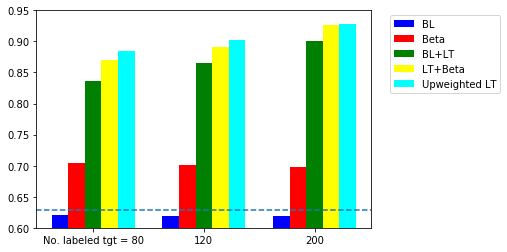

In [20]:
index = np.array([1, 2, 3])
bar_width = 0.15
color_list = ['blue','red', 'green', 'yellow','cyan']
label_list = ['BL', 'Beta', 'BL+LT', 'LT+Beta', 'Upweighted LT']
for i in range(5):
    plt.bar(index + i*bar_width, results_summary[:,i], bar_width, \
            color = color_list[i], label = label_list[i])
plt.xticks(index + 2*bar_width, ('No. labeled tgt = 80','120', '200' ))
plt.ylim(0.6,0.95)
plt.axhline(y = 0.628, ls = '--')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.savefig("AccSpamSup_{}_to_{}.png".format(src,tgt), bbox_inches="tight")

In [22]:
X_tgt.shape

(2500, 10000)